# 6 - Construindo um LLM do Zero: GPT — Do Token ao Texto

Este é o **sexto** de uma série de oito artigos que podem ser encontrados no meu medium. Acesse o primeiro artigo da série aqui: [Construindo um LLM: entendendo os Grandes Modelos de Linguagem](https://blog.zfab.me/construindo-um-llm-entendendo-os-grandes-modelos-de-linguagem-b37884219eaa)

----
Chegamos ao momento em que concluímos nosso modelo e o deixamos pronto para ser pré-treinado. Nos artigos anteriores, exploramos os conceitos fundamentais de tokenização, embeddings, multi-head attention e a arquitetura do bloco Transformer. Agora, daremos o passo final: montar o modelo GPT completo e funcional.

In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.nn import functional as F
import sentencepiece as spm
import numpy as np

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12})

In [50]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self, d_in, d_out, context_length, n_heads, qkv_bias=False, dropout=0.1
    ):
        super().__init__()

        assert d_out % n_heads == 0, "d_out deve ser divisível por num_heads"

        self.d_out = d_out
        self.n_heads = n_heads
        self.d_head = d_out // n_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        n_batch, n_tokens, _ = x.size()

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(n_batch, n_tokens, self.n_heads, self.d_head)
        keys = keys.view(n_batch, n_tokens, self.n_heads, self.d_head)
        values = values.view(n_batch, n_tokens, self.n_heads, self.d_head)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1)
        attention_scores.masked_fill_(
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf
        )

        attention_weights = torch.softmax(
            attention_scores / keys.size(-1) ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(n_batch, n_tokens, self.d_out)
        context_vector = self.out_proj(context_vector)

        return context_vector

class LayerNorm(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.eps = 1e-6  # Epsilon para evitar divisão por zero
        self.scale = nn.Parameter(
            torch.ones(d_emb)
        )  # Gamma - Inicializando com 1 para não alterar a escala
        self.shift = nn.Parameter(
            torch.zeros(d_emb)
        )  # Beta - Inicializando com 0 para não alterar o deslocamento

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift  # Gamma * x_norm + Beta

class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

class FeedForward(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_emb, d_emb * 4),
            GeLU(),
            nn.Linear(d_emb * 4, d_emb),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_emb, n_heads, context_length, dropout=0.1, qkv_bias=False):
        super().__init__()
        self.mha = MultiHeadAttention(
            d_in=d_emb,
            d_out=d_emb,
            context_length=context_length,
            n_heads=n_heads,
            dropout=dropout,
            qkv_bias=qkv_bias,
        )
        self.ff = FeedForward(d_emb)
        self.norm1 = LayerNorm(d_emb)
        self.norm2 = LayerNorm(d_emb)
        self.drop_shortcut = nn.Dropout(dropout)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)  # 1
        x = self.mha(x)  # 2
        x = self.drop_shortcut(x)  # 3
        x = x + shortcut  # 4

        shortcut = x
        x = self.norm2(x)  # 5
        x = self.ff(x)  # 6
        x = self.drop_shortcut(x)  # 7
        x = x + shortcut  # 8
        return x


Finalizando a arquitetura GPT
A arquitetura GPT (Generative Pre-trained Transformer) é baseada em uma pilha de blocos Transformer, especificamente o decodificador. Sua principal característica é ser um modelo autoregressivo, ou seja, gera um token com base nos tokens anteriores, e esse resultado é alimentado como entrada para geração do próximo token. Este processo se repete até que uma condição de parada seja atingida, geralmente a presença de um token especial de fim de sentença (eos).

Fazendo uma retrospectiva dos artigos anteriores, já temos todos os blocos necessários para a construção do nosso modelo

Camada de Embedding: Converte tokens em representações vetoriais contínuas.
Embeddings Posicionais: Adiciona informações de posição aos embeddings de tokens para manter a ordem sequencial.
Blocos Transformer: Cada bloco contém mecanismos de atenção mascarada, normalização e redes feedforward.
Agora precisamos apenas conectar tudo isso e adicionar duas últimas camadas ao final do último bloco transformer: uma Layer Normalization, que vimos no artigo anterior, e uma camada Linear, semelhante a Feed Foward Network que também vimos anteriormente

![Modelo Autorregressivo](../assets/6-AUTORREGRESSIVO.png)

A camada LayerNorm, como discutido anteriormente, servirá para normalizar as representações garantindo estabilidade numérica. Já a camada linear tem a função crucial de projetar os vetores da dimensão do embedding (tamanho d_emb) para a dimensão do vocabulário completo, transformando matrizes de formato (Número de Tokens × Tamanho do Embedding) em (Número de Tokens × Tamanho do Vocabulário).

Com essa transformação, o modelo gera, para cada posição na sequência de entrada, um vetor contendo valores logit para cada token do vocabulário. Logits são valores numéricos que representam as “pontuações brutas” atribuídas pelo modelo a cada token do vocabulário.

Ao aplicarmos a função softmax nos logits, eles se convertem em distribuições de probabilidade sobre todo o vocabulário, indicando a chance de cada token ser o próximo na sequência. Com essa informação conseguimos, por exemplo, prever o próximo token como aquele com maior probabilidade e então concatenar esse novo token à sequência e jogá-la toda novamente para dentro do modelo.

Vamos criar, finalmente nosso modelo:

In [51]:
class GPTModel(nn.Module):
    def __init__(self, 
        d_vocab,
        d_emb,
        context_length,
        n_layers,
        n_heads,
        dropout,
        qkv_bias        
    ):
        super().__init__()
        self.context_length = context_length

        # Embedding de tokens e de posição
        self.tok_emb = nn.Embedding(d_vocab, d_emb)
        self.pos_emb = nn.Embedding(context_length, d_emb)
        self.drop_emb = nn.Dropout(dropout)

        # Sequência de Blocos Transformers
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(d_emb, n_heads, context_length, dropout, qkv_bias) for _ in range(n_layers)]
        )

        # Normalização e projeção para o vocabulário
        self.final_norm = LayerNorm(d_emb)
        self.out_head = nn.Linear(d_emb, d_vocab, bias=False)
        
        # Inicialização dos pesos
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # Embedding de tokens e de posição
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        # Sequência de Blocos Transformers
        x = self.trf_blocks(x)

        # Normalização e projeção para o vocabulário
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
    # Função para gerar texto
    def generate(self, input, max=200):
        for _ in tqdm(range(max), desc="Gerando Tokens..."):
            input = input[:, -self.context_length:] # Garantindo que o seja no máximo do tamanho do contexto. 
            logits = self(input)
            logits = logits[:, -1, :]
            prob = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(prob, num_samples=1)
            input = torch.cat([input, next_token], dim=-1)
        return input


Como podem ver, estamos simplesmente pegando nosso vetor de tokens, transformando-os em embeddings, passando esses embeddings pelos blocos transformers e, ao final, normalizando e projetando esses embeddings na dimensão do vocabulário.

Também que estamos aplicando uma função para inicializar os pesos do modelo. Essa inicialização serve para termos uma convergência mais estável e rápida durante o treinamento.

Estamos utilizando a inicialização normal (gaussiana) com média 0 e desvio padrão de 0.02 para os pesos lineares e de embedding, ou seja, os pesos iniciais são amostrados com essa distribuição. Os vieses (quando presentes) inicializamos com zeros.

Essas escolhas de inicialização baseiam-se em práticas padrão que se mostraram eficazes em modelos transformers. Como ocorre com muitos aspectos na área de Deep Learning, não sabemos exatamente o porquê funciona — temos uma noção, mas não a certeza — e por isso continuamos aplicando.

Agora vamos testar nosso modelo. Primeiro, criaremos duas frases de exemplo e converteremos essas frases em vetores de tokens usando nosso tokenizador, que foi desenvolvido no segundo artigo desta série.

In [ ]:
frase_1 = "Olá Mundo, tudo bem?<|eos|>"
frase_2 = "Criando meu primeiro LLM<|eos|>"

tk = spm.SentencePieceProcessor(
    model_file="../models/gigaverbo_tk.model"
)  # Instanciando o tokenizador treinado

frase_1_encode = tk.encode(frase_1)
frase_2_encode = tk.encode(frase_2)

batch = torch.tensor([frase_1_encode, frase_2_encode])

print("Frase 1", frase_1_encode)
print("Frase 2", frase_2_encode)

Frase 1 [3188, 4047, 2362, 341, 4040, 1927, 824, 4091, 3]
Frase 2 [346, 444, 341, 2390, 1429, 495, 4085, 4068, 3]


Agrupamos as duas frases em um batch (conjunto) e passaremos ele como entrada pro nosso modelo. Vamos criar um modelo usando as configurações do GPT-2 small

In [ ]:
torch.manual_seed(123)
model = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=1024,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=False,
)

out = model(batch)
print("Input batch:", batch.shape)
print("Output shape: ", out.shape)
print("Logits (Último Token, Primeira frase): ", out[0, -1, :])

Input batch: torch.Size([2, 9])
Output shape:  torch.Size([2, 9, 4096])
Logits (Último Token, Primeira frase):  tensor([ 0.7082,  0.7826, -0.1804,  ...,  1.1423,  0.1249,  0.4783],
       grad_fn=<SliceBackward0>)


Como entrada (input batch) temos nossas 2 frases, ambas com o comprimento de 9 tokens (o equivalente a [2, 9, 1]). Ao passar pelo modelo, vemos que a saída é um tensor ainda com 2 frases de 9 tokens, porém agora a última dimensão tem tamanho 4096, que corresponde ao tamanho do nosso vocabulário.

Para prevermos a próxima palavra, sempre pegaremos o último token da frase (já que ele está prevendo sempre o próximo token) e, com base nos logits, escolhemos qual seria o token mais provável dentre as 4096 opções que nosso vocabulário oferece.

In [ ]:
top5 = torch.topk(out[0, -1, :], k=5).indices
print("Top 5 IDs tokens mais prováveis: ", top5)
for i in top5:
    print(f"Token ({i.item()}): {tk.decode_ids([i.item()])}")

Top 5 IDs tokens mais prováveis:  tensor([ 114, 2943, 3100, 1369, 3151])
Token (114): n
Token (2943): quí
Token (3100): Aqui
Token (1369): animais
Token (3151): istir


Analisando a primeira frase e o último token, podemos identificar os maiores logits e definir uma regra de seleção, como escolher o token com o maior valor. No exemplo acima, listamos os 5 tokens com os maiores logits, obtivemos seus IDs (identificando suas posições no vetor) e verificamos no vocabulário quais palavras eles representam.

É importante destacar que poderíamos aplicar a função `softmax` nos logits para obter as probabilidades associadas a cada token, convertendo os valores brutos em uma distribuição de probabilidade normalizada. No entanto, ao buscarmos apenas os tokens com os maiores valores, como fizemos com a função `torch.topk()`, não precisamos da softmax. Isso ocorre porque a função softmax preserva a ordem dos valores—o maior logit continuará correspondendo à maior probabilidade—portanto, para simplesmente identificar os tokens mais prováveis, podemos trabalhar diretamente com os logits.

Nesse nosso exemplo, o token com maior logit é o 114, que representa a letra "n". Portanto, nosso modelo está prevendo que para a sequência `Olá Mundo, tudo bem?<|eos|>` o próximo token seria `n`.

Obviamente não faz sentido, mas vale lembrarmos que não treinamos ainda o modelo — ele está com os pesos aleatórios e, portanto, está funcionando de maneira totalmente estocástica. Ou seja, prever com ele ou fazendo uma jogada de moeda pra cima, dá no mesmo.

Pronto, temos nosso modelo funcional, basta treina-lo para que ele comece a se comportar como um LLM de verdade.  Vamos verificar com quantos parâmetros nosso modelo ficou

In [ ]:
model_gpt2 = GPTModel(
    d_vocab=50257, # Nosso vocabulário é muito menor que o do GPT-2
    d_emb=768,
    context_length=1024,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=False,
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Número de Parâmetros: {total_params:,}")

total_params = sum(p.numel() for p in model_gpt2.parameters())
print(f"Número de Parâmetros GPT-2 Small: {total_params:,}")

Número de Parâmetros: 92,106,240
Número de Parâmetros GPT-2 Small: 163,009,536


Vemos que nosso modelo ficou com "apenas" 92 milhões de parâmetros. Apesar da arquitetura e configurações serem praticamente as mesmas do GPT-2 Small, temos um vocabulário mais de 10x menor, o que resulta nessa diferença significativa.

Leitores mais curiosos notarão que o GPT-2 em sua versão Small tem cerca de 124 milhões de parâmetros, porém a nossa “replica” aparece com 163M. Por que essa diferença?

## Weight Tying

Uma técnica usada na construção de LLMs é o conceito de **weight tying** (compartilhamento de pesos). Esta prática consiste em compartilhar os mesmos pesos entre a camada de embedding de entrada e a camada linear de saída do modelo, que projeta os embeddings de volta em tokens.

Em nossa replica do GPT, isso significaria que os pesos da camada `tok_emb` (responsável por converter IDs de tokens em embeddings) seriam os mesmos utilizados na camada `out_head` (que projeta os embeddings de volta para o espaço do vocabulário).

In [ ]:
print("Camada Token -> Embedding (tok_emb):", model.tok_emb.weight.shape)
print("Camada Embedding -> Token (out_head):", model.out_head.weight.shape)

Camada Token -> Embedding (tok_emb): torch.Size([4096, 768])
Camada Embedding -> Token (out_head): torch.Size([4096, 768])


O weight tying oferece algumas vantagens:

- **Redução significativa de parâmetros:** Para um vocabulário típico de 50.000 tokens e dimensão de embedding de 768, economizamos cerca de 38 milhões de parâmetros (50.000 × 768).
- **Melhoria na generalização:** O compartilhamento de pesos funciona como uma forma de regularização, forçando o modelo a aprender representações mais robustas e coerentes.
- **Aceleração da convergência:** Modelos com weight tying tendem a convergir mais rapidamente durante o treinamento.

A intuição por trás dessa técnica é que existe uma relação simétrica entre a tarefa de converter tokens em representações semânticas (embedding) e a tarefa inversa de projetar representações semânticas de volta para probabilidades sobre o vocabulário (classificação).

Estudos empíricos, como o apresentado no artigo [*Using the Output Embedding to Improve Language Models*](https://arxiv.org/abs/1608.05859) (Press & Wolf, 2016), demonstraram que esta técnica não apenas reduz a quantidade de parâmetros, mas também melhora o desempenho do modelo em várias tarefas de linguagem.

Para implementar o weight tying em nosso modelo GPT, basta adicionar uma linha de código após a inicialização das camadas no método `__init__`:

In [57]:
class GPTModel(nn.Module):
    def __init__(
        self, d_vocab, d_emb, context_length, n_layers, n_heads, dropout, qkv_bias
    ):
        super().__init__()
        self.context_length = context_length

        # Embedding de tokens e de posição
        self.tok_emb = nn.Embedding(d_vocab, d_emb)
        self.pos_emb = nn.Embedding(context_length, d_emb)
        self.drop_emb = nn.Dropout(dropout)

        # Sequência de Blocos Transformers
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(d_emb, n_heads, context_length, dropout, qkv_bias)
                for _ in range(n_layers)
            ]
        )

        # Normalização e projeção para o vocabulário
        self.final_norm = LayerNorm(d_emb)
        self.out_head = nn.Linear(d_emb, d_vocab, bias=False)

        # Inicialização dos pesos
        self.apply(self._init_weights)

        # Weight tying
        self.out_head.weight = self.tok_emb.weight


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # Embedding de tokens e de posição
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        # Sequência de Blocos Transformers
        x = self.trf_blocks(x)

        # Normalização e projeção para o vocabulário
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    # Função para gerar texto
    def generate(self, input, max=200):
        for _ in tqdm(range(max), desc="Gerando Tokens..."):
            input = input[
                :, -self.context_length :
            ]  # Garantindo que o seja no máximo do tamanho do contexto.
            logits = self(input)
            logits = logits[:, -1, :]
            prob = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(prob, num_samples=1)
            input = torch.cat([input, next_token], dim=-1)
        return input

Esta simples modificação tornará nosso modelo mais eficiente tanto em termos de memória quanto de desempenho. Vamos verificar os parâmetros novamente

In [ ]:
model = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=1024,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=False,
)

model_gpt2 = GPTModel(
    d_vocab=50257,  # Nosso vocabulário é muito menor que o do GPT-2
    d_emb=768,
    context_length=1024,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=False,
)

total_params_model = sum(p.numel() for p in model.parameters())
print(f"Número de Parâmetros: {total_params_model:,}")

total_params_model_gpt2 = sum(p.numel() for p in model_gpt2.parameters())
print(f"Número de Parâmetros GPT-2 Small: {total_params_model_gpt2:,}")

Número de Parâmetros: 88,960,512
Número de Parâmetros GPT-2 Small: 124,412,160


Enquanto nosso modelo “perdeu” cerca de 3M de parâmetros, a nossa réplica do GPT-2 chegou aos famosos 124M. Com isso conseguimos calcular o tamanho que esses modelos ocupariam na memória.

In [ ]:
total_size_bytes = total_params_model * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Tamanho total do modelo: {total_size_mb:.2f} MB")

total_size_bytes = total_params_model_gpt2* 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Tamanho total do modelo GPT-2 Small: {total_size_mb:.2f} MB")

Tamanho total do modelo: 339.36 MB
Tamanho total do modelo GPT-2 Small: 474.59 MB


Para calcular o tamanho, multiplicamos o número de parâmetros pelo espaço necessário para armazenar cada um em ponto flutuante (4 bytes para precisão simples). Por exemplo, usando precisão simples (float32), nosso modelo de ~89M de parâmetros ocuparia aproximadamente 339 MB apenas para os pesos, enquanto o GPT-2 Small necessitaria de cerca de 474 MB.

## Geração de Texto com o nosso Modelo

Antes de partirmos para o pré-treinamento, é interessante entender como utilizaremos o output do nosso modelo para gerar texto. O processo é autoregressivo: alimentamos o modelo com as previsões anteriores até atingirmos o comprimento desejado ou um token de parada.

Leitores mais atentos notaram que adicionamos uma função de geração no código do modelo. Vamos entendê-la:

```python
    def generate(self, input, max=200):
        for _ in tqdm(range(max), desc="Gerando Tokens..."):
            input = input[:, -self.context_length:] # (1) Garantindo que o seja no máximo do tamanho do contexto. 
            logits = self(input) # (2)
            logits = logits[:, -1, :] # (3)
            prob = F.softmax(logits, dim=-1) # (4)
            next_token = torch.multinomial(prob, num_samples=1) # (5)
            input = torch.cat([input, next_token], dim=-1) # (6)
        return input
```

A função recebe uma sequência de tokens (input) e repete uma série de passos para gerar uma quantidade predeterminada de tokens (max).

Em cada iteração, primeiro truncamos o input (1) para garantir que não exceda o tamanho máximo do contexto (definimos em nosso modelo 1024 tokens). Em seguida, passamos o input pelo modelo (2) para obter os logits e selecionamos apenas os logits do último token da sequência (3).

Aplicamos a função softmax para converter os logits em probabilidades (4) e, usando a função multinomial, amostramos o próximo token (5).

Por fim, concatenamos o token amostrado à sequência de input (6), que será usado na próxima iteração (1).

Vamos criar uma função de apoio para auxiliar a geração de texto

In [60]:
@torch.no_grad()  # (1)
def generate_sample(model, input_text, max_token=200):
    input_tokens = torch.tensor(tk.encode(input_text), dtype=torch.long)  # (2)
    input_tokens = input_tokens.unsqueeze(0)  # (3)

    output = model.generate(input_tokens, max_token)  # (4)
    output_text = tk.decode(output.squeeze().tolist())  # (5)

    return output_text  # (6)

Essa função recebe uma string de texto e a quantidade máxima de tokens como entrada. Ela prepara o texto para ser enviado ao modelo e, posteriormente, converte a saída do modelo de volta para texto.

O decorador @torch.no_grad (1) desativa o cálculo de gradientes durante a inferência, pois estes são necessários apenas durante o treinamento.

Em seguida, convertemos o texto de entrada em tokens usando nosso tokenizador (2) e adicionamos uma dimensão extra (3), pois precisamos passar o tensor no formato (batch x tokens). Depois, chamamos a função generate do modelo (4) que vimos anteriormente.

O output do modelo é então convertido de volta em texto usando o decode do tokenizador (5) e, por fim, retornamos o texto gerado (6).

In [ ]:
texto_gerado = generate_sample(model, "Olá Mundo, tudo bem?", 15)
print(texto_gerado)

texto_gerado = generate_sample(model, "Olá Mundo, tudo bem?", 15)
print(texto_gerado)

Gerando Tokens...: 100%|██████████| 15/15 [00:00<00:00, 19.20it/s]


Olá Mundo, tudo bem?ru escolh` luta andocaelo im segui Au Exemp duas Ch virtual altura


Gerando Tokens...: 100%|██████████| 15/15 [00:00<00:00, 19.79it/s]

Olá Mundo, tudo bem?ign num clientesvidaaráliseiaíb Os Pla eficiente algumasistemasicul qu


Podemos ver que está funcionando. O resultado ainda é sem sentido mas podemos ver que mesmo passando a mesma frase de entrada obtemos resultados diferentes. 

Diferente do **método *greedy***, que usamos anteriormente, onde simplesmente selecionamos o token com o maior logit (e, portanto, maior probabilidade), a amostragem probabilística oferece uma abordagem mais rica e flexível. Em vez de uma escolha determinística (maior logit), usamos uma função multinomial para sortear o próximo token, com base em sua probabilidade.

A função `torch.multinomial` é a chave para essa amostragem baseada em probabilidades. Imagine um sorteio de palavras do vocabulário, onde cada palavra tem um peso proporcional à sua probabilidade. Palavras com maior probabilidade têm mais chances de serem sorteadas, mas palavras com menor probabilidade ainda têm uma chance de serem escolhidas. Este processo introduz uma aleatoriedade controlada na geração, permitindo que o modelo explore diferentes caminhos e evite respostas repetitivas.

É por isso que, mesmo fornecendo o mesmo texto de entrada, obtemos resultados diferentes, diferentemente do que aconteceria se sempre escolhêssemos o token com maior logit. Como o processo é autoregressivo, essas pequenas variações se acumulam durante a geração, resultando em frases completamente distintas.

Mas como podemos controlar essa aleatoriedade e direcionar a geração para resultados mais "criativos" quando necessário e mais conservadores em outros momentos? Para isso, existem algumas técnicas de amostragem:

### **Temperature Scaling (T)**

O parâmetro **Temperature (T)** é um hiperparâmetro crucial que ajusta a distribuição de probabilidades dos tokens. Em essência, ele "achata" ou "aguça" a distribuição de probabilidades, influenciando a diversidade das saídas.

Para isso, basta dividirmos os logits por (T) antes de aplicar a função softmax. Essa simples divisão traz um comportamento interessante:

- **(T > 1): Mais Criatividade -** Uma temperatura maior que 1 torna a distribuição mais uniforme, dando mais chances para tokens menos prováveis. Isso resulta em texto mais diverso, criativo. Use (T > 1) para tarefas que exigem um toque artístico, como:
- **(T < 1): Mais Precisão -** Uma temperatura menor que 1 concentra a distribuição nos tokens mais prováveis, tornando a geração mais conservadora e precisa.
- **(T = 1): Equilíbrio -** Uma temperatura igual a 1 mantém a distribuição original sem modificação, oferecendo um ponto de partida neutro.

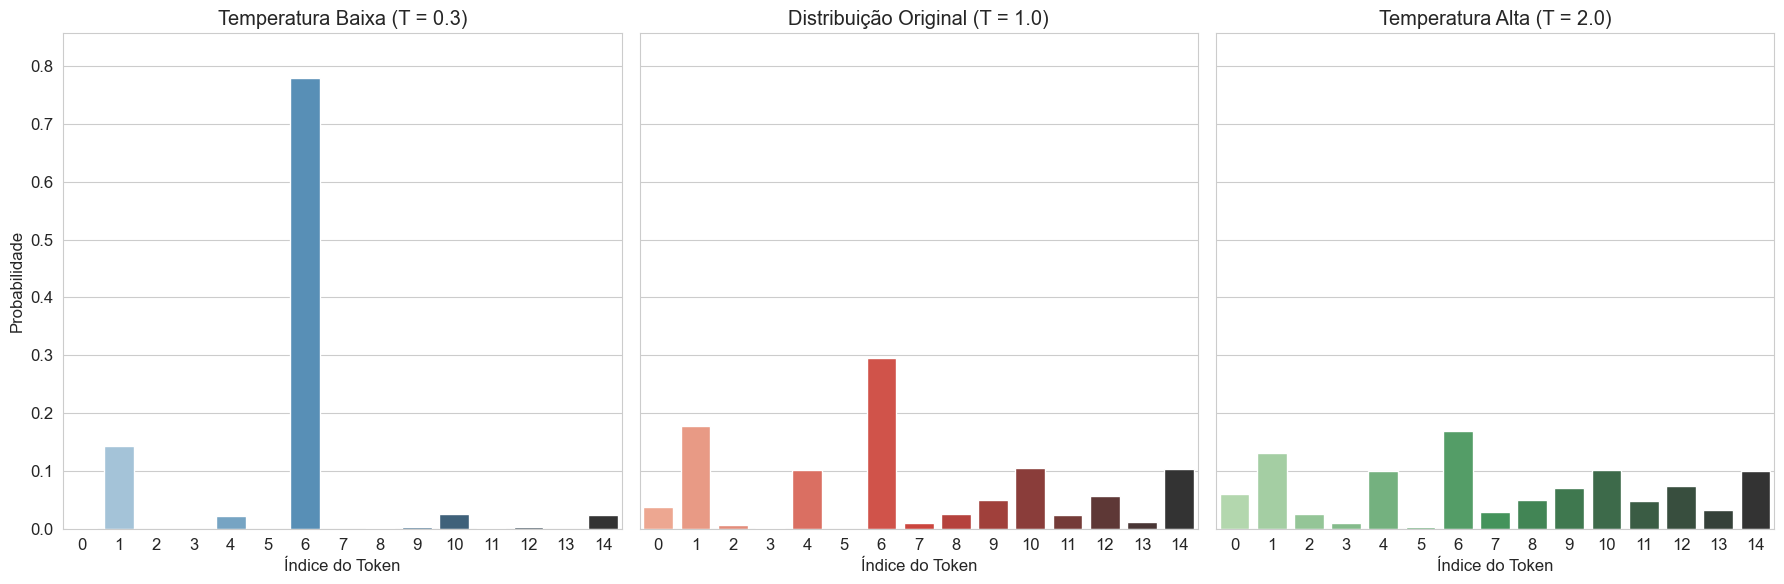

In [62]:
# Criando uma distribuição aleatória de 15 tokens
np.random.seed(42)
random_probs = np.random.dirichlet(
    np.ones(15) * 0.5
)
probs = torch.tensor(random_probs, dtype=torch.float32)
num_tokens = len(probs)

# Temperaturas para os gráficos de barras
temp_low = 0.3  # Temperatura baixa
temp_high = 2.0  # Temperatura alta

# Calculando as probabilidades com temperaturas ajustadas
logits = torch.log(probs)  # Convertendo probabilidades de volta para logits
probs_low = F.softmax(logits / temp_low, dim=0).numpy()
probs_high = F.softmax(logits / temp_high, dim=0).numpy()

# Preparando o gráfico
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Gráfico de barras para temperatura baixa
sns.barplot(
    x=np.arange(num_tokens), 
    y=probs_low, 
    ax=axes[0], 
    hue=np.arange(num_tokens), 
    legend=False, 
    palette="Blues_d"
)
axes[0].set_title(f"Temperatura Baixa (T = {temp_low})")
axes[0].set_xlabel("Índice do Token")
axes[0].set_ylabel("Probabilidade")
axes[0].set_xticks(np.arange(num_tokens))
axes[0].set_ylim(
    0, max(np.max(probs_low), np.max(probs.numpy()), np.max(probs_high)) * 1.1
)

# Gráfico da distribuição original
sns.barplot(
    x=np.arange(num_tokens), 
    y=probs.numpy(), 
    ax=axes[1], 
    hue=np.arange(num_tokens), 
    legend=False, 
    palette="Reds_d"
)
axes[1].set_title("Distribuição Original (T = 1.0)")
axes[1].set_xlabel("Índice do Token")
axes[1].set_xticks(np.arange(num_tokens))

# Gráfico de barras para temperatura alta
sns.barplot(
    x=np.arange(num_tokens),
    y=probs_high,
    ax=axes[2],
    hue=np.arange(num_tokens),
    legend=False,
    palette="Greens_d",
)
axes[2].set_title(f"Temperatura Alta (T = {temp_high})")
axes[2].set_xlabel("Índice do Token")
axes[2].set_xticks(np.arange(num_tokens))

plt.tight_layout()


Podemos perceber pelos gráficos que temperaturas mais baixas modificam a distribuição de modo a realçar os picos da distribuição original, enquanto temperaturas altas tendem a equalizar as probabilidades.

### **Top-k Sampling**

A técnica **Top-k Sampling** restringe a amostragem apenas aos (k) tokens mais prováveis, ajudando a evitar escolhas improváveis que poderiam prejudicar a coerência do texto. Pense nisso como um filtro que remove as opções mais "malucas" do sorteio.

O valor de (k) é crucial. Um valor **muito baixo pode tornar o texto repetitivo** e previsível, enquanto um valor **muito alto pode não filtrar** suficientemente as opções indesejadas.

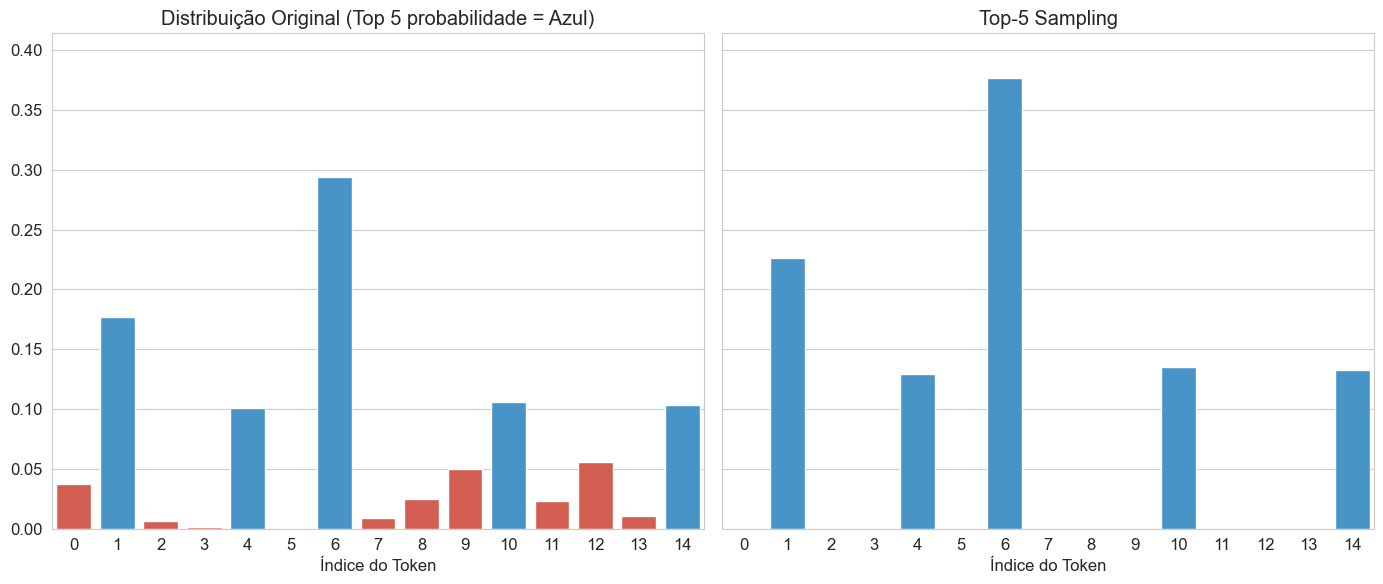

In [63]:
# Criando uma distribuição aleatória de 15 tokens
np.random.seed(42)
random_probs = np.random.dirichlet(
    np.ones(15) * 0.5
)  # Distribuição Dirichlet para gerar probabilidades aleatórias
probs = torch.tensor(random_probs, dtype=torch.float32)
num_tokens = len(probs)

# Definindo o valor de k para o Top-K Sampling
k = 5

# Aplicando Top-K Sampling
values, indices = torch.topk(probs, k=k)
top_k_probs = torch.zeros_like(probs)
top_k_probs[indices] = values

# Renormalizando as probabilidades após o Top-K
top_k_probs = top_k_probs / top_k_probs.sum()

# Preparando o gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Criando uma paleta de cores para destacar os tokens selecionados
colors_original = ["#3498db" if i in indices else "#e74c3c" for i in range(num_tokens)]
colors_topk = ["#3498db" if i in indices else "#e74c3c" for i in range(num_tokens)]

# Gráfico da distribuição original
sns.barplot(
    x=np.arange(num_tokens),
    y=probs.numpy(),
    ax=axes[0],
    hue=np.arange(num_tokens),
    legend=False,
    palette=colors_original,
)
axes[0].set_title("Distribuição Original (Top 5 probabilidade = Azul)")
axes[0].set_xlabel("Índice do Token")
axes[0].set_xticks(np.arange(num_tokens))

# Gráfico de barras para Top-K Sampling
sns.barplot(
    x=np.arange(num_tokens), y=top_k_probs.numpy(), ax=axes[1], hue=np.arange(num_tokens), legend=False, palette=colors_topk
)
axes[1].set_title(f"Top-{k} Sampling")
axes[1].set_xlabel("Índice do Token")
axes[1].set_ylabel("Probabilidade")
axes[1].set_xticks(np.arange(num_tokens))
axes[1].set_ylim(
    0, max(np.max(probs.numpy()), np.max(top_k_probs.numpy())) * 1.1
)

plt.tight_layout()


O gráfico demonstra claramente o efeito da técnica Top-K: ela remove da "disputa" todos os tokens que não estão entre os K mais prováveis e reajusta as probabilidades apenas para esses tokens selecionados

### **Top-P (Nucleus) Sampling**

O **Top-P Sampling**, também conhecido como **Nucleus Sampling**, é uma técnica que, diferentemente do Top-k, não fixa um número arbitrário de tokens. Em vez disso, seleciona o menor conjunto de tokens cuja probabilidade cumulativa excede um limiar (p).

Imagine que estamos construindo um "núcleo" de tokens: começamos pelos mais prováveis e vamos adicionando outros até que a probabilidade total desse núcleo atinja (p). A amostragem considera apenas os tokens dentro desse núcleo.

Quando o modelo está muito confiante em alguns tokens, o núcleo permanece pequeno, favorecendo a precisão. Quando está incerto, o núcleo se expande, permitindo maior diversidade.

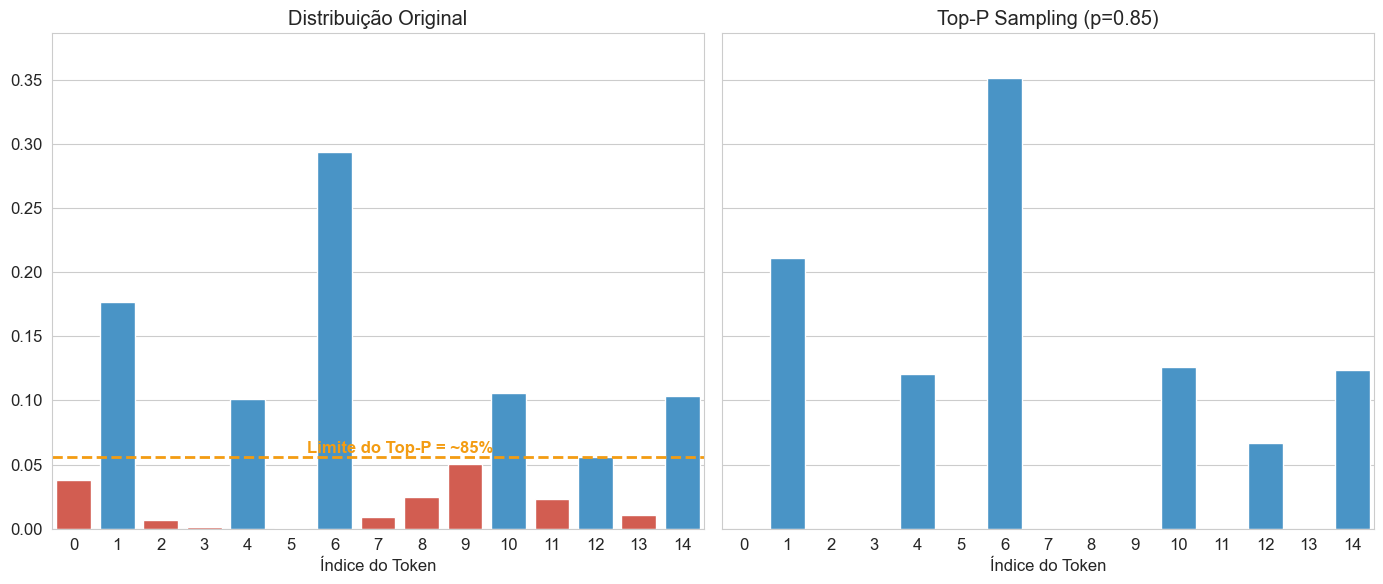

In [64]:
# Criando uma distribuição aleatória de 15 tokens
np.random.seed(42)
random_probs = np.random.dirichlet(
    np.ones(15) * 0.5
)  # Distribuição Dirichlet para gerar probabilidades aleatórias
probs = torch.tensor(random_probs, dtype=torch.float32)
num_tokens = len(probs)

# Definindo o valor de p para o Top-P (Nucleus) Sampling
p = 0.85  # Vamos manter tokens que somam 70% da probabilidade total

# Aplicando Top-P Sampling
sorted_probs, sorted_indices = torch.sort(probs, descending=True)
cumulative_probs = torch.cumsum(sorted_probs, dim=0)
sorted_indices_to_remove = cumulative_probs > p

nucleus_mask = torch.ones_like(probs, dtype=torch.bool)
nucleus_mask[sorted_indices[sorted_indices_to_remove]] = False

# Aplicando a máscara para obter as probabilidades após o Top-P
top_p_probs = probs.clone()
top_p_probs[~nucleus_mask] = 0

# Renormalizando as probabilidades após o Top-P
top_p_probs = top_p_probs / top_p_probs.sum()

# Contando quantos tokens foram mantidos
num_tokens_kept = nucleus_mask.sum().item()

# Preparando o gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Criando uma paleta de cores para destacar os tokens selecionados
colors_original = [
    "#3498db" if nucleus_mask[i] else "#e74c3c" for i in range(num_tokens)
]
colors_topp = ["#3498db" if nucleus_mask[i] else "#e74c3c" for i in range(num_tokens)]

# Gráfico da distribuição original
sns.barplot(
    x=np.arange(num_tokens),
    y=probs.numpy(),
    ax=axes[0],
    hue=np.arange(num_tokens),
    legend=False,
    palette=colors_original,
)
axes[0].set_title("Distribuição Original")
axes[0].set_xlabel("Índice do Token")
axes[0].set_xticks(np.arange(num_tokens))

# Adicionando uma linha horizontal para mostrar o "corte" do Top-P
cumsum_threshold = None
for i, cum_prob in enumerate(cumulative_probs):
    if cum_prob > p:
        cumsum_threshold = i
        break

if cumsum_threshold is not None:
    # Adicionando uma linha no gráfico original para mostrar o limite do Top-P
    axes[0].axhline(
        y=sorted_probs[cumsum_threshold - 1],
        color="#f39c12",
        linestyle="--",
        linewidth=2,
    )
    axes[0].text(
        num_tokens / 2,
        sorted_probs[cumsum_threshold - 1] * 1.05,
        f"Limite do Top-P = ~{p * 100:.0f}%",
        ha="center",
        color="#f39c12",
        fontweight="bold",
    )

# Gráfico de barras para Top-P Sampling
sns.barplot(
    x=np.arange(num_tokens),
    y=top_p_probs.numpy(),
    ax=axes[1],
    hue=np.arange(num_tokens),
    legend=False,
    palette=colors_topp,
)
axes[1].set_title(f"Top-P Sampling (p={p})")
axes[1].set_xlabel("Índice do Token")
axes[1].set_ylabel("Probabilidade")
axes[1].set_xticks(np.arange(num_tokens))
axes[1].set_ylim(
    0, max(np.max(probs.numpy()), np.max(top_p_probs.numpy())) * 1.1
)

plt.tight_layout()

No gráfico vemos que os tokens com maior probabilidade são selecionados até atingir a probabilidade cumulativa definida por p (no gráfico é 85%). Ou seja, se somarmos as probabilidades da barras azuis do gráfico da esquerda teremos um valor próximo de 85%.

### Ajustando nossa função

A beleza dessas técnicas reside em sua capacidade de serem combinadas para obter resultados ainda melhores. Por exemplo, é comum usar Temperature junto com Top-k Sampling ou Top-P Sampling para ter um controle mais fino sobre a aleatoriedade, mantendo a coerência do texto.

Ao ajustar cuidadosamente os parâmetros de Temperature, Top-k e Top-P, podemos guiar nossos modelos de linguagem para gerar textos que sejam, ao mesmo tempo, criativos, coerentes e relevantes para a tarefa. 

Vamos adicionar esses 3 parâmetros em nosso modelo

In [65]:
class GPTModel(nn.Module):
    def __init__(
        self, d_vocab, d_emb, context_length, n_layers, n_heads, dropout, qkv_bias
    ):
        super().__init__()
        self.context_length = context_length

        # Embedding de tokens e de posição
        self.tok_emb = nn.Embedding(d_vocab, d_emb)
        self.pos_emb = nn.Embedding(context_length, d_emb)
        self.drop_emb = nn.Dropout(dropout)

        # Sequência de Blocos Transformers
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(d_emb, n_heads, context_length, dropout, qkv_bias)
                for _ in range(n_layers)
            ]
        )

        # Normalização e projeção para o vocabulário
        self.final_norm = LayerNorm(d_emb)
        self.out_head = nn.Linear(d_emb, d_vocab, bias=False)

        # Inicialização dos pesos
        self.apply(self._init_weights)

        # Weight tying
        self.out_head.weight = self.tok_emb.weight


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # Embedding de tokens e de posição
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        # Sequência de Blocos Transformers
        x = self.trf_blocks(x)

        # Normalização e projeção para o vocabulário
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    # Função para gerar texto
    def generate(self, input, max=200, temperature=1.0, top_k=0, top_p=1.0):
        for _ in tqdm(range(max), desc="Gerando Tokens..."):
            input = input[
                :, -self.context_length :
            ]  # Garantindo que o seja no máximo do tamanho do contexto.
            logits = self(input)
            logits = logits[:, -1, :]
            
            # Aplicando temperature
            logits = logits / temperature
            
            # Aplicando top_k se especificado
            if top_k > 0:
                top_k_values, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                logits = torch.full_like(logits, float('-inf'))
                logits.scatter_(1, top_k_indices, top_k_values)
            
            # Aplicando top_p (nucleus sampling) se menor que 1.0
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Remove tokens com probabilidade cumulativa acima do threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift para manter pelo menos um token
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[..., indices_to_remove] = float('-inf')
            
            # Convertendo para probabilidades e amostrando
            prob = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(prob, num_samples=1)
            input = torch.cat([input, next_token], dim=-1)
        return input

A função acima foi modificada para incorporar as técnicas que estudamos anteriormente. Embora o código pareça complexo, sua essência realiza exatamente o que vimos:

- Temperature divide os logits pelo valor do parâmetro Temperature
- Top K seleciona os K maiores logits e define o restante como `-inf`, fazendo com que a Softmax resulte em zero para esses valores (seguindo o mesmo princípio usado para zerar a probabilidade dos tokens futuros no mecanismo de atenção)
- Top P converte os logits em probabilidades usando Softmax, seleciona os maiores tokens até que sua soma atinja o valor p, e atribui `-inf` aos logits restantes

Após essas modificações nos logits, aplicamos a softmax para gerar a distribuição de probabilidade e selecionamos o próximo token usando a função multinomial

In [66]:
model = GPTModel(
    d_vocab=tk.vocab_size(),
    d_emb=768,
    context_length=1024,
    n_layers=12,
    n_heads=12,
    dropout=0.1,
    qkv_bias=False,
)

@torch.no_grad()
def generate_sample(model, input_text, max_token=200, temperature=1, top_k=0, top_p=1):
    input_tokens = torch.tensor(tk.encode(input_text), dtype=torch.long)
    input_tokens = input_tokens.unsqueeze(0)

    output = model.generate(input_tokens, max_token, temperature, top_k, top_p)
    output_text = tk.decode(output.squeeze().tolist())

    return output_text

In [ ]:
texto_gerado = generate_sample(model, "Olá Mundo, tudo bem?", 15, 0.7, 50, 0.9)
print(texto_gerado)

Gerando Tokens...: 100%|██████████| 15/15 [00:00<00:00, 23.47it/s]

Olá Mundo, tudo bem? benefícios risco un depoisgaG Enquantoânndemia telaga quí pe então depois


Podemos testar nossa nova função. Obviamente o resultado ainda é totalmente sem sentido mas isso mudará a partir do próximo artigo!

# Conclusão

Neste artigo, finalizamos a montagem do nosso GPT — um LLM criado do zero! Ao longo desta série, exploramos em profundidade sua arquitetura e funcionamento, implementamos todos os componentes essenciais (desde a camada de embeddings até o decoder transformer completo) e concluímos com técnicas de geração de texto.

Descobrimos que mesmo um modelo relativamente "pequeno" como o nosso, com cerca de 89M de parâmetros, apresenta uma complexidade considerável em sua arquitetura e requisitos computacionais.

No próximo artigo, abordaremos o momento mais aguardado: o pré-treinamento do nosso modelo, que o transformará de um simples gerador de tokens aleatórios em um **verdadeiro LLM**.